# PS2 Econ 571 

In [29]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import sklearn
import math
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller # Dickey-Fuller test
from statsmodels.tsa.statespace.tools import diff # difference operator 
%matplotlib inline

In [15]:
gdp_df = pd.read_csv("./data/USGDP.csv")
money_df = pd.read_csv("./data/USMoney.csv")
print("gdp:" + str(gdp_df.shape) + " money:" + str(money_df.shape)) 

gdp:(283, 4) money:(708, 5)


In [16]:
gdp_df.GDP = gdp_df.GDP.apply(lambda x: float(x.replace(',','')))

In [17]:
# transform months to quarters and average the data
amoney_df = money_df.groupby(money_df.index // 3, ).mean()
amoney_df.Month = (amoney_df.index % 4) + 1
amoney_df = amoney_df.rename(columns={'Month':'Quarter'})

In [18]:
gdp_cols = ['Year', 'Quarter', 'GDP']
amoney_df = pd.merge(amoney_df, gdp_df[['Year', 'Quarter', 'GDP', 'GDPDEF']], on=['Year', 'Quarter'], how='inner')

In [19]:
# adjust for inflation using GDP deflator. 
amoney_df.M1 = (amoney_df.M1 / amoney_df.GDPDEF) * 100
amoney_df.M2 = (amoney_df.M2 / amoney_df.GDPDEF) * 100
amoney_df.GDP = ((amoney_df.GDP / amoney_df.GDPDEF) * 100)
amoney_df = amoney_df.rename(columns={'GDP':'RGDP'})

In [20]:
# create an annual version of the data. 
qmoney_df = amoney_df  # quarters
ymoney_df = amoney_df.head(232).groupby(amoney_df.head(232).index // 4, ).mean()
ymoney_df.Year =  ymoney_df.Year.astype(int)
ymoney_df.shape

(58, 7)

In [21]:
# quarterly train and test. 
q_lnM1 = np.log(qmoney_df.M1) / np.log(math.e)
q_lnM2 = np.log(qmoney_df.M2) / np.log(math.e)
q_X = qmoney_df.drop(['M1', 'M2', 'Year', 'Quarter', 'GDPDEF'], axis=1)
q_X = np.log(q_X) / np.log(math.e)
q_X = sm.add_constant(q_X)  # add a column of ones. 

#yearly train and test
y_lnM1 = np.log(ymoney_df.M1) / np.log(math.e)
y_lnM2 = np.log(ymoney_df.M2) / np.log(math.e)
y_X = ymoney_df.drop(['M1', 'M2', 'Year', 'Quarter', 'GDPDEF'], axis=1)
y_X = np.log(y_X) / np.log(math.e)
y_X = sm.add_constant(y_X)

/usr/local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


# Dickey-Fuller test on ln(RGDP) 

In [24]:
# Prefrom the Dickey-Fuller test on ln(RGDP)
# this loop will automatically choose the correct number of difference
i = 0
result = None
while True: 
    q_X_d = diff(q_X.RGDP, k_diff=i)
    result = adfuller(q_X_d, regression='c')
    print("-------------------------------")
    print(str(i) + "th degree difference")
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('used lags: %f' % result[2])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    print("-------------------------------")
    if result[1] < 0.05: 
        break
    i += 1

-------------------------------
0th degree difference
ADF Statistic: -2.188110
p-value: 0.210589
used lags: 2.000000
Critical Values:
	1%: -3.459
	5%: -2.874
	10%: -2.573
-------------------------------
-------------------------------
1th degree difference
ADF Statistic: -7.464437
p-value: 0.000000
used lags: 1.000000
Critical Values:
	1%: -3.459
	5%: -2.874
	10%: -2.573
-------------------------------


## Mean is not stationary given the rolling mean

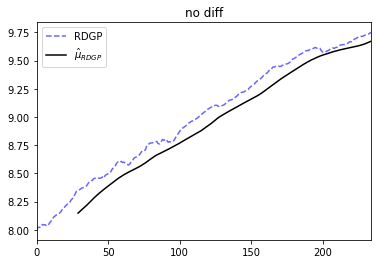

In [77]:
q_X.RGDP.plot(style='k--', c='b', alpha=0.6)
ax = q_X.RGDP.rolling(30).mean().plot(style='k', title="no diff")
ax.legend(['RDGP', r'$\hat{\mu}_{RDGP}$'])
#ax.get_figure().savefig('figures/m_0diff.pdf')

## variance seems fairly stationary, jumping around 0.07

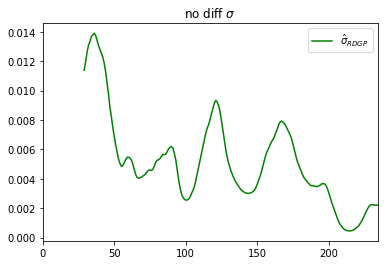

In [84]:
ax = q_X.RGDP.rolling(30).var().plot(style='g', title=r'no diff $\sigma$')
ax.legend([r'$\hat{\sigma}_{RDGP}$'])
#ax.get_figure().savefig('figures/s_0diff.pdf')

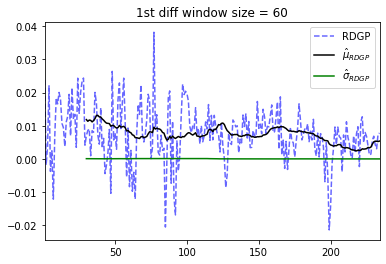

In [86]:
diff1 = diff(q_X.RGDP, k_diff=1)
diff1.plot(style='k--', c='b', alpha=0.6)
ax = diff1.rolling(30).mean().plot( style='k', legend=True, title=r'1st diff window size = 60')
ax = diff1.rolling(30).var().plot( style='g', legend=True, title=r'1st diff window size = 60')
ax.legend(['RDGP', r'$\hat{\mu}_{RDGP}$', r'$\hat{\sigma}_{RDGP}$'])
#ax.get_figure().savefig('figures/sm_1diff.pdf')

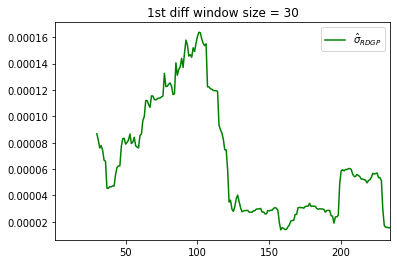

In [87]:
ax = diff1.rolling(30).var().plot( style='g', legend=True, title=r'1st diff window size = 30')
ax.legend([r'$\hat{\sigma}_{RDGP}$'])
#ax.get_figure().savefig('figures/s_1diff.pdf')

# ACF and PCAF

In [88]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

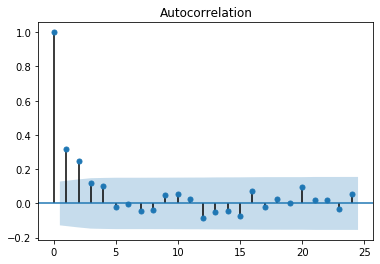

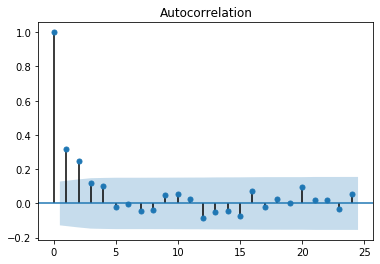

In [90]:
plot_acf(diff1)

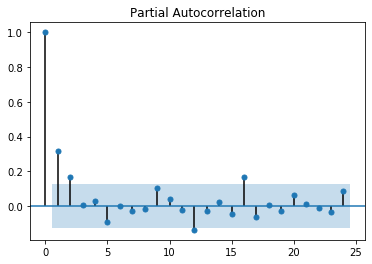

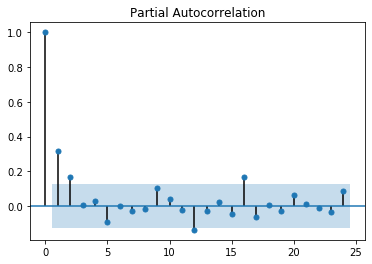

In [91]:
plot_pacf(diff1)